## Data story: exploring startup data
****
Goal: to explore and understand available datasets on the subject

Data source: https://www.crunchbase.com/
****

I was curious to learn what data would say about startups. Which countries have the most startups? What is the percentage of those startups that are still operating vs. those that have already closed? Where do investors like to invest their money? And how do investors ultimately influence their portfolio companies (as manifested by the number of acquisitions made by those startups, for example)?

The data for the project came from crunchbase, a data company. 

Crunchbase data on startups is broken down into three separate datasets: <b>companies</b> (with specific information on companies), <b>acquisitions</b> (which includes information on acquisitions by startups and of startsups), and <b>investments</b> (which focuses on VC funding rounds into startups).

The three datasets used in the project were downloaded on <b>December 4th 2015</b> and were made available on github by a different user. 

Use of this data is governed by the [CrunchBase Terms of Service and Licensing Policy](https://about.crunchbase.com/docs/terms-of-service/). 
****

Let's start by loading different packages that will help us explore all three datasets

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import seaborn as sb

<b>Companies dataset </b>

Next, we will begin by exploring the first dataset, companies.csv. 

In [20]:
companies = pd.DataFrame.from_csv('companies.csv', index_col=None)

In [21]:
companies[0:4]

,permalink,name,homepage_url,category_code,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at,last_milestone_at,id
0,/company/8868,8868,http://www.8868.cn,NaN,NaN,operating,NaN,NaN,unknown,NaN,1,NaN,NaN,NaN,NaN,12/1/2013,12/1/2013,NaN,1
1,/company/21e6,2.10E+07,NaN,NaN,5050000.0,operating,USA,CA,SF Bay,San Francisco,1,1/1/2013,2013-01,2013-Q1,2013.0,11/17/2013,11/17/2013,NaN,2
2,/company/club-domains,.Club Domains,http://dotclub.com,software,7000000.0,operating,USA,FL,Fort Lauderdale,Oakland Park,1,10/10/2011,2011-10,2011-Q4,2011.0,5/31/2013,5/31/2013,NaN,3
3,/company/fox-networks,.Fox Networks,http://www.dotfox.com,advertising,4912394.0,closed,ARG,NaN,Buenos Aires,Buenos Aires,1,NaN,NaN,NaN,NaN,1/16/2007,1/16/2007,7/1/2008,4


We can also look at one specific company on the list:

In [22]:
companies.ix[1]

permalink            /company/21e6
name                      2.10E+07
homepage_url                   NaN
category_code                  NaN
funding_total_usd         5.05e+06
status                   operating
country_code                   USA
state_code                      CA
region                      SF Bay
city                 San Francisco
funding_rounds                   1
founded_at                1/1/2013
founded_month             2013-01 
founded_quarter            2013-Q1
founded_year                  2013
first_funding_at        11/17/2013
last_funding_at         11/17/2013
last_milestone_at              NaN
id                               2
Name: 1, dtype: object

Even though it might seem that there is something wrong with the company name, the company's real name is in fact 21e6 -- it's a bitcoin startup. Its cell type is questionable, however.

Another observation is that several fields for this company have missing information, and we will have to account for that in our future analysis.

Next, let's check the type of our date-containing columns, because dates will be key to understanding startup evolution in our future analysis. There are 7 columns with dates in our current dataset. The last, milestone column is one example of such dates columns.

In [23]:
companies['last_milestone_at'].describe()

count        14604
unique        1915
top       1/1/2012
freq           567
Name: last_milestone_at, dtype: object

Now we are aware that all of the date columns are of the type object. We will remember that when cleaning our data further down the line.

Next, let's ask a few questions about the dataset to get to know that data better.

### 1. How many companies are in the database and what is the distrubution of companies across the globe?

In [4]:
companies['permalink'].count()

27327

In [5]:
countries = companies.country_code.dropna()
from collections import Counter
countries_dict = Counter(countries)
sorted_countries = sorted(countries_dict.items(), key = lambda x: x[1], reverse = True)
sorted_countries[0:14]

[('USA', 17053),
 ('GBR', 1629),
 ('CAN', 852),
 ('DEU', 622),
 ('FRA', 589),
 ('IND', 505),
 ('ISR', 457),
 ('ESP', 309),
 ('CHN', 299),
 ('SWE', 227),
 ('ITA', 202),
 ('AUS', 201),
 ('IRL', 193),
 ('NLD', 181)]

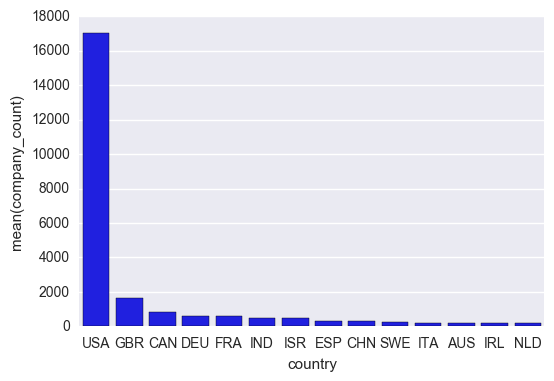

In [41]:
countries_df = pd.DataFrame(sorted_countries[0:14])
countries_df.columns = ['country', 'company_count']

%matplotlib inline

sb.barplot(x ='country', y ='company_count', color = 'blue', data = countries_df)


Looking at the chart, we can already tell that the majority of startups are based in the US, with UK and Canada being distant second and third.

### 2. How many companies are operating and how many have closed. 

Another important question for our analysis is the distribution of operating and closed companies. 

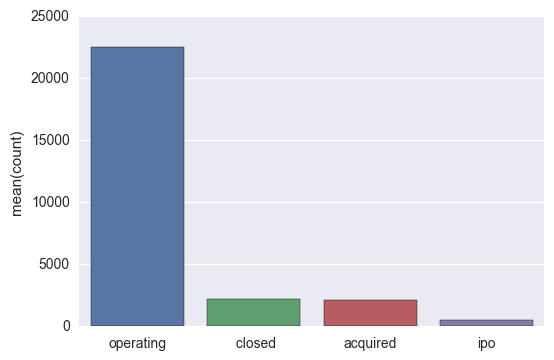

In [89]:
operating = companies[companies.status == 'operating'].permalink.count()
closed = companies[companies.status == 'closed'].permalink.count()
acquired = companies[companies.status == 'acquired'].permalink.count()
ipo = companies[companies.status == 'ipo'].permalink.count()
oper_closed_dict = {'operating':operating, 'closed': closed, 'acquired': acquired, 'ipo': ipo}
oper_closed_df = pd.DataFrame.from_dict(oper_closed_dict, orient = 'index')

oper_closed_df.columns = ['count']
sb.barplot(data = oper_closed_df, x = ['operating', ' closed', 'acquired', 'ipo'], y = 'count')

In [90]:
oper_closed_df

,count
operating,22523
acquired,2176
closed,2153
ipo,475


Based on the data, we can see that less than 10% of companies are identified as closed in the database, while a similar number of startups has already been acquired.

It is those closed (unsuccessful) vs. acquired or listed (successful) companies that we will be particularly interested in later in our analysis.

Visualizing total funding and status (operating or closed) would also be interesting to see the full picture.

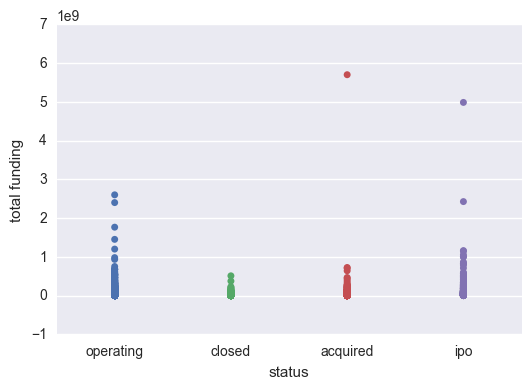

In [88]:
total_funding = companies['funding_total_usd']
status = companies['status']
funding_vs_status = {'total funding': total_funding, 
                     'status': status}
fund_vs_status_df = pd.DataFrame(funding_vs_status)

sb.stripplot(x = 'status', y = 'total funding', data = fund_vs_status_df)

What should be noted here is that the range of total funding for companies that have closed is smaller than that for acquired companies and even smaller than total funding for those companies that went through an IPO. Closed companies also don't have any outliers, implying that none of those companies had extremely high overall funding.

Now, let's see if there is any interesting trend when it comes to the dates associated with each company.
First we will extract the dates into a separate dataframe.

In [97]:
founded = companies['founded_at']
first_round = companies['first_funding_at']
last_round = companies['last_funding_at']

funding_dict = {'founded': founded, 
                'first round': first_round,
                'last round': last_round}

funding_df = pd.DataFrame(funding_dict)

### 3. Determine the ratio of operating to closed for each investor

In [ ]:
## Step 1: need to merge companies and investments data
investments = pd.DataFrame.from_csv('investments.csv', index_col=None)

investments[0:4]
len(investments['company_permalink'])

In [ ]:
investments = investments.rename(columns = {'company_permalink': 'permalink'})
companies_investments = pd.merge (companies, investments, on = 'permalink')

len(companies_investments['permalink'])

In [ ]:
companies_investments[companies_investments.permalink == '/company/8868']